# 04 - Tendência Mann-Kendall e Sen’s Slope

Este notebook aplica o teste de Mann-Kendall e calcula a inclinação de Sen para:

- Frequência e intensidade de EPI, EPN e EPF

- Em escala **anual** e **sazonal**

Saídas geradas:
- `z_*.nc`: mapa Z-statistic

- `slope_*.nc`: inclinação de Sen (variação por ano)

- `sig_*.nc`: mapa binário de significância (p < 0.05)


## Importações e parâmetros

In [1]:
import xarray as xr
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Diretórios de entrada e saída
base_dir = "dataset/netcdf_data/freq_intensidade"
saida_dir = "dataset/netcdf_data/tendencia"
os.makedirs(saida_dir, exist_ok=True)

## Funções Mann-Kendall e Sen’s Slope

In [3]:
def mann_kendall_pixel(series):
    """
    Aplica Mann-Kendall a uma série 1D.
    Retorna Z-statistic.
    """
    series = series[~np.isnan(series)]
    n = len(series)
    if n < 2:
        return 0.0

    # S
    s = 0
    for k in range(n-1):
        s += np.sum(np.sign(series[k+1:] - series[k]))

    # Correção para empates
    unique_vals, counts = np.unique(series, return_counts=True)
    tie_sum = np.sum(counts*(counts-1)*(2*counts+5))
    var_s = (n*(n-1)*(2*n+5) - tie_sum) / 18.0

    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    return z


def sens_slope_pixel(series, anos):
    """
    Calcula Sen’s slope (mediana das inclinações) para série 1D.
    """
    series = series[~np.isnan(series)]
    anos = anos[:len(series)]
    n = len(series)
    if n < 2:
        return 0.0

    slopes = []
    for i in range(n-1):
        slopes.extend((series[i+1:] - series[i]) / (anos[i+1:] - anos[i]))
    return np.median(slopes)

## Processar dados

In [4]:
def calcular_mk_sen_array(da):
    """
    Aplica MK e Sen’s slope em todas as grades de um DataArray.
    Retorna: z_map, slope_map, sig_map
    """
    anos = da.year.values if "year" in da.dims else np.arange(da.shape[0])

    # Converter para (pixels, tempo)
    data = da.values.reshape(da.shape[0], -1).T  # (pixels, tempo)

    # MK e Sen pixel a pixel
    z_vals = np.apply_along_axis(mann_kendall_pixel, 1, data)
    slope_vals = np.apply_along_axis(sens_slope_pixel, 1, data, anos)

    # p-valor e significância
    p_vals = 2 * (1 - norm.cdf(np.abs(z_vals)))
    sig_vals = (p_vals < 0.05).astype(int)

    # Reconstruir mapas
    shape_map = da.shape[1:]  # (lat, lon)
    z_map = z_vals.reshape(shape_map)
    slope_map = slope_vals.reshape(shape_map)
    sig_map = sig_vals.reshape(shape_map)

    # Criar DataArrays com coords
    template = da.isel({list(da.dims)[0]: 0})
    z_da = xr.DataArray(z_map, coords={"lat": template.lat, "lon": template.lon}, dims=("lat", "lon"))
    slope_da = xr.DataArray(slope_map, coords={"lat": template.lat, "lon": template.lon}, dims=("lat", "lon"))
    sig_da = xr.DataArray(sig_map, coords={"lat": template.lat, "lon": template.lon}, dims=("lat", "lon"))

    return z_da, slope_da, sig_da


## Teste em um pixel central

In [5]:
# Exemplo com frequência EPI anual
arquivo_teste = os.path.join(base_dir, "freq_epi_anual.nc")
da_teste = xr.open_dataarray(arquivo_teste)

# Testar pixel central
lat_central = int(len(da_teste.lat) / 2)
lon_central = int(len(da_teste.lon) / 2)

serie_teste = da_teste[:, lat_central, lon_central].values
print("Série pixel central:", serie_teste)
print("Z MK pixel central:", mann_kendall_pixel(serie_teste))
print("Slope pixel central:", sens_slope_pixel(serie_teste, da_teste.year.values))


Série pixel central: [1 0 0 1 3 1 1 2 1 0 1 1 0 1 0 1 2 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0
 0 0 0 1 1 0]
Z MK pixel central: -2.119016185170656
Slope pixel central: 0.0


## Processar e salvar todas as combinações

In [6]:
# Lista de arquivos no diretório freq_intensidade
arquivos = sorted([os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith(".nc")])

for arq in arquivos:
    nome_base = os.path.splitext(os.path.basename(arq))[0]
    print(f"Processando {nome_base}...")
    da = xr.open_dataarray(arq)

    z_da, slope_da, sig_da = calcular_mk_sen_array(da)

    # Salvar
    z_da.to_netcdf(os.path.join(saida_dir, f"z_{nome_base}.nc"))
    slope_da.to_netcdf(os.path.join(saida_dir, f"slope_{nome_base}.nc"))
    sig_da.to_netcdf(os.path.join(saida_dir, f"sig_{nome_base}.nc"))

print("Processamento completo!")


Processando freq_epf_anual...
Processando freq_epf_sazonal...
Processando freq_epi_anual...
Processando freq_epi_sazonal...
Processando freq_epn_anual...
Processando freq_epn_sazonal...
Processando int_epf_anual...
Processando int_epf_sazonal...
Processando int_epi_anual...
Processando int_epi_sazonal...
Processando int_epn_anual...
Processando int_epn_sazonal...
Processamento completo!


## Visualização rápida

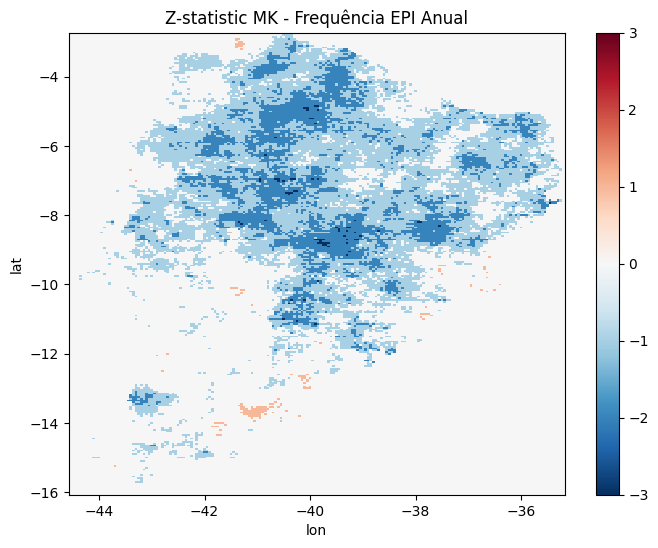

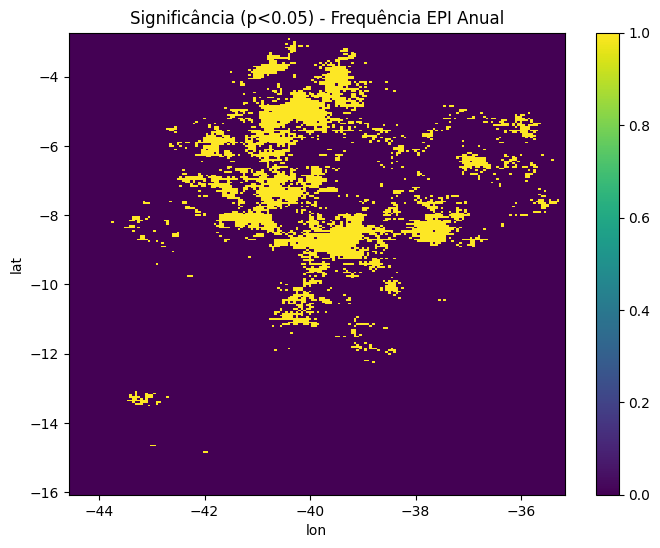

In [7]:
z_plot = xr.open_dataarray(os.path.join(saida_dir, "z_freq_epi_anual.nc"))
sig_plot = xr.open_dataarray(os.path.join(saida_dir, "sig_freq_epi_anual.nc"))

z_plot.plot(figsize=(8,6))
plt.title("Z-statistic MK - Frequência EPI Anual")
plt.show()

sig_plot.plot(figsize=(8,6))
plt.title("Significância (p<0.05) - Frequência EPI Anual")
plt.show()
